In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append(os.path.abspath(os.path.join('../../../../BayesFlow_dev/BayesFlow/')))

from src.python.settings import DEFAULT_KEYS
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.losses import softmax_loss
from src.python.visualization import perf_tester

import numpy as np
import bayesflow as bf
import tensorflow as tf
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

c:\Users\lasse\projects\BayesFlow_dev\BayesFlow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 640x480 with 0 Axes>

# Load network

In [3]:
sum_config = {"units": 128, "activation": "elu", "kernel_initializer": "glorot_normal"}
summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(dense_s2_args=sum_config, dense_s3_args=sum_config), 
    bf.networks.DeepSet(dense_s2_args=sum_config, dense_s3_args=sum_config)
    ])
probability_net = bf.inference_networks.PMPNetwork(num_models=2, dropout=False)
amortizer = bf.amortizers.AmortizedModelComparison(probability_net, summary_net)

In [4]:
# Training steps
epochs = 50 
iterations_per_epoch = 1000

# Checkpoint path for loading pretrained network and saving the final network
# TEMPORARY: SPECIFIC FOLDER
checkpoint_path = 'C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models/40_epochs_lr1e4_128eluglorotnormal_0.177avg.loss'

trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    default_lr=0.0001,
    checkpoint_path=checkpoint_path
    )

# Sample size
n_clusters = 25
n_obs = 50

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models/40_epochs_lr1e4_128eluglorotnormal_0.177avg.loss\history_40.pkl.
INFO:root:Networks loaded from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models/40_epochs_lr1e4_128eluglorotnormal_0.177avg.loss\ckpt-40


# Get OOD score

## Utility functions

In [5]:
def noise_simulator(batch_size, n_clusters=25, n_obs=50, RNG=None, **kwargs):
    """ Generates a single hierarchical data set. """
    if RNG is None:
        RNG = np.random.default_rng()
    data = RNG.integers(low=0, high=2, size=(batch_size, n_clusters, n_obs, 2)) 
    #data = RNG.integers(low=-100, high=101, size=(batch_size, n_clusters, n_obs, 2))

    out_dict = {
        DEFAULT_KEYS["sim_data"]: data,
    }

    return out_dict

In [6]:
# Generative models
sdtmpt_model = HierarchicalSdtMptSimulator()

sdt_simulator = partial(sdtmpt_model.generate_batch, model_index=0, n_clusters=n_clusters, n_obs=n_obs, n_vars=2)
mpt_simulator = partial(sdtmpt_model.generate_batch, model_index=1, n_clusters=n_clusters, n_obs=n_obs, n_vars=2)

In [7]:
def get_max_activation(data, probability_net, summary_net, method):
    """ Gets the inference networks' last-layer-activation, either before or after 
    passing it through the softmax function. """

    if method=='max_softmax':
        activations = np.concatenate([probability_net.posterior_probs(summary_net(chunk)) for chunk in tf.split(data, 20)])
    if method=='max_logits':
        activations = np.concatenate([probability_net.logits(summary_net(chunk)) for chunk in tf.split(data, 20)])
          
    max_activation = np.max(activations, axis=1)

    return max_activation

## Data generation

In [8]:
num_data_sets = 5000

sdt_data = sdt_simulator(num_data_sets)['sim_data']
mpt_data = mpt_simulator(num_data_sets)['sim_data']
noise_data = noise_simulator(num_data_sets)['sim_data']

## max_softmax

In [9]:
sdt_max_softmax = get_max_activation(sdt_data, probability_net, summary_net, 'max_softmax')
mpt_max_softmax = get_max_activation(mpt_data, probability_net, summary_net, 'max_softmax')
noise_max_softmax = get_max_activation(noise_data, probability_net, summary_net, 'max_softmax')
print(np.mean(sdt_max_softmax), np.mean(mpt_max_softmax), np.mean(noise_max_softmax))

0.94107443 0.93043244 0.99419767


In [10]:
def get_percentage_rejected(model_activations, noise_activations, ci=[0.025, 0.975]):

    proportions_rejected = []

    for activations in model_activations:
        lower_threshold, upper_threshold = np.quantile(activations, q=ci, axis=0)
        print(lower_threshold, upper_threshold)
        print(np.max(noise_activations))
        rejected = np.logical_or(noise_activations < lower_threshold, noise_activations > upper_threshold)
        proportion_rejected = np.sum(rejected) / len(noise_activations)
        proportions_rejected.append(proportion_rejected)

    return proportions_rejected

get_percentage_rejected([sdt_max_softmax, mpt_max_softmax], noise_max_softmax)

0.5776163235306739 0.9969472840428353
0.99599946
0.5745288699865341 0.9970065638422966
0.99599946


[0.0, 0.0]

Text(0.5, 1.0, 'MaxSoftmax')

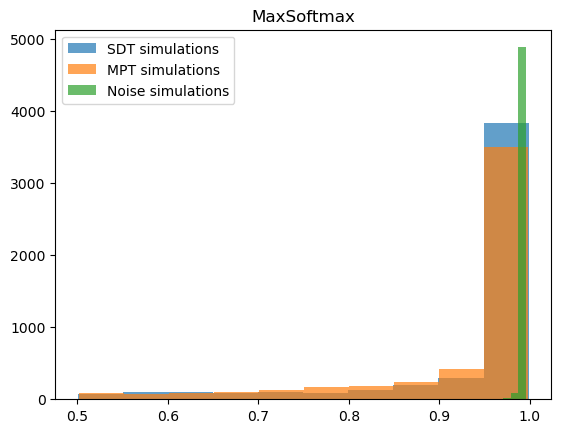

In [11]:
plt.hist(sdt_max_softmax, alpha=0.7, label='SDT simulations')
plt.hist(mpt_max_softmax, alpha=0.7, label='MPT simulations')
plt.hist(noise_max_softmax, alpha=0.7, label='Noise simulations')
plt.legend()
plt.title('MaxSoftmax')

## max_logits

In [12]:
#import tensorflow as tf
#tf.random.set_seed(2023) 
# fixes wildly differing results - but why are they so different when reloading the net in the first place??

sdt_max_logits = get_max_activation(sdt_data, probability_net, summary_net, 'max_logits')
mpt_max_logits = get_max_activation(mpt_data, probability_net, summary_net, 'max_logits')
noise_max_logits = get_max_activation(noise_data, probability_net, summary_net, 'max_logits')
print(np.mean(sdt_max_logits), np.mean(mpt_max_logits), np.mean(noise_max_logits))

1.61704 1.9826535 2.1628158


Text(0.5, 1.0, 'MaxLogit')

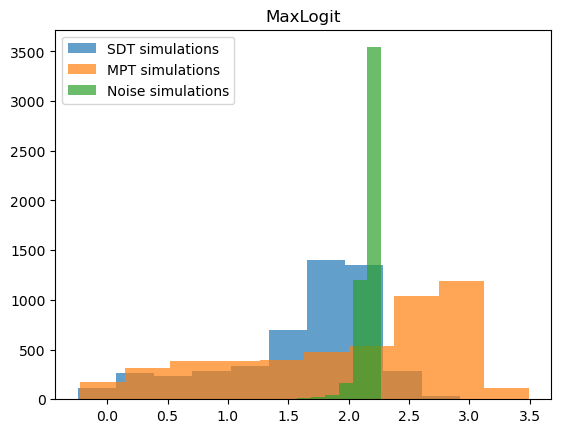

In [13]:
plt.hist(sdt_max_logits, alpha=0.7, label='SDT simulations')
plt.hist(mpt_max_logits, alpha=0.7, label='MPT simulations')
plt.hist(noise_max_logits, alpha=0.7, label='Noise simulations')
plt.legend()
plt.title('MaxLogit')

# Inspect predictions 

## SDT MPT data

ECE = 0.010


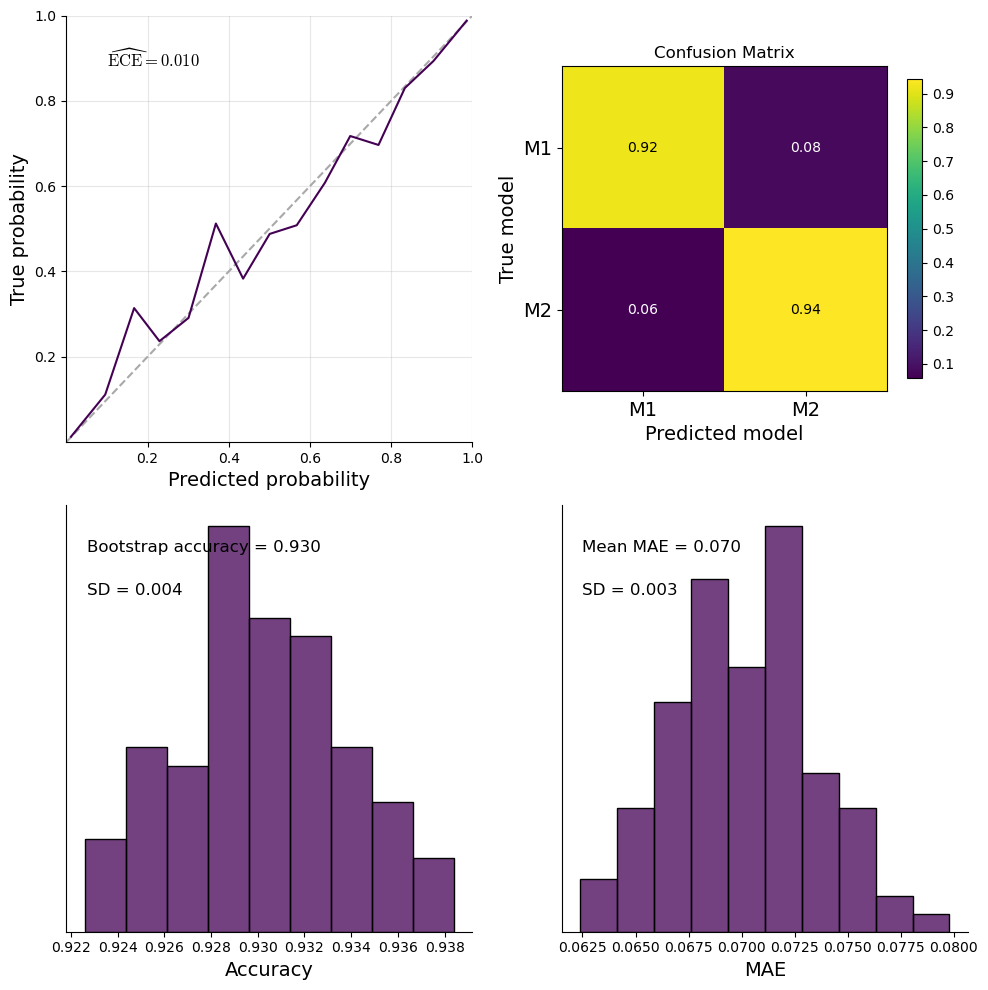

In [14]:
meta_model = bf.simulation.MultiGenerativeModel([sdt_simulator, mpt_simulator])
val_data = trainer.configurator(meta_model(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

## Noisy data

ECE = 0.496


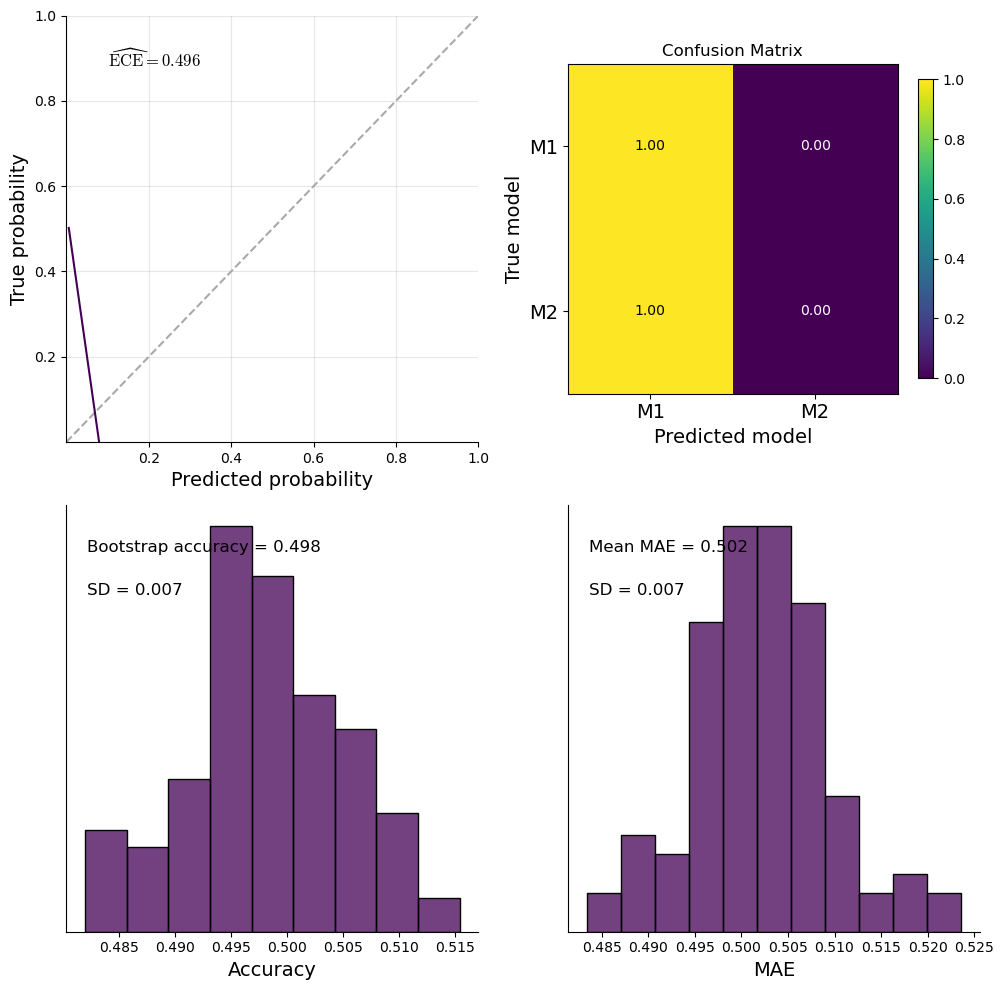

In [15]:
meta_noise = bf.simulation.MultiGenerativeModel([noise_simulator,noise_simulator])
val_data = trainer.configurator(meta_noise(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

In [16]:
# check that both columns of simulated noise data are random
np.mean(noise_data, axis=(0,1,2))

array([0.5000712, 0.4996304])

In [17]:
# inspect predictions
noise_softmax = np.concatenate([probability_net.posterior_probs(summary_net(chunk)) for chunk in tf.split(noise_data, 20)])
np.mean(noise_softmax, axis=0)

array([0.9942003 , 0.00580234], dtype=float32)

In [18]:
noise_softmax[:10,:]

array([[0.9926318 , 0.00736819],
       [0.9953199 , 0.00468006],
       [0.99153394, 0.0084661 ],
       [0.9896638 , 0.01033627],
       [0.9950023 , 0.00499769],
       [0.9954412 , 0.00455882],
       [0.9949674 , 0.00503258],
       [0.9953284 , 0.00467156],
       [0.99279624, 0.00720371],
       [0.99517316, 0.00482683]], dtype=float32)

In [19]:
# inspect logits
noise_logits=np.concatenate([probability_net.logits(summary_net(chunk)) for chunk in tf.split(noise_data, 20)])
np.mean(noise_logits, axis=0)

array([ 2.162815, -3.042499], dtype=float32)

In [20]:
noise_logits[:10,:]

array([[ 2.1413558, -2.7618325],
       [ 2.174116 , -3.185637 ],
       [ 2.098676 , -2.6645079],
       [ 2.0224981, -2.5392082],
       [ 2.2333653, -3.060403 ],
       [ 2.1729584, -3.2131646],
       [ 2.203731 , -3.0830455],
       [ 2.2233777, -3.138201 ],
       [ 2.1489727, -2.776956 ],
       [ 2.2111835, -3.117542 ]], dtype=float32)

# Generate and save test data for comparison with bridge sampling

In [21]:
n_data_sets = 100
n_clusters = 25
n_obs = 50

noise_data_ood = noise_simulator(n_data_sets, RNG=np.random.default_rng(2023))['sim_data']

In [22]:
# save data sets
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison','non_nested_models')

np.save(os.path.join(val_folder, 'noise_data_ood'), noise_data_ood)

# Compare predictions

In [23]:
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison', 'non_nested_models')
bridge_file = '2023_06_16_BF_BS_ood'
bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN = probability_net.posterior_probs(summary_net(noise_data_ood))

results_list = [bridge, NN]

In [24]:
NN_array = np.array(NN[:, 0])

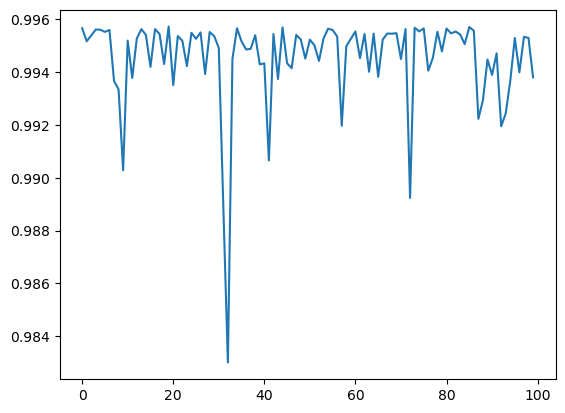

In [25]:
plt.plot(NN_array)

In [26]:
bridge_array = np.array(bridge.loc[:, "m0_prob"])

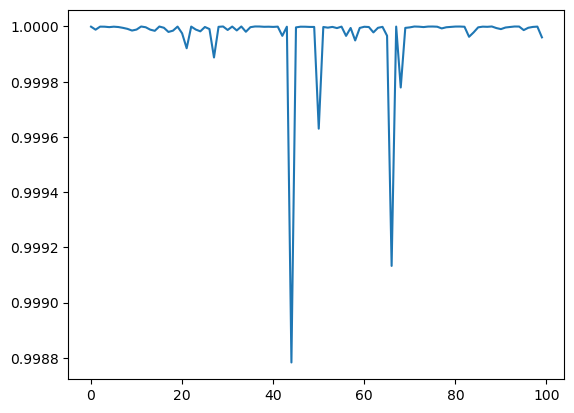

In [27]:
plt.plot(bridge_array)

In [28]:
NN_array

array([0.99566084, 0.9951698 , 0.99538773, 0.99561346, 0.99560416,
       0.9955231 , 0.9955949 , 0.99366814, 0.9933437 , 0.99028254,
       0.9951931 , 0.99378043, 0.9952733 , 0.9956269 , 0.9954105 ,
       0.99419844, 0.9956287 , 0.9954418 , 0.9943065 , 0.9957287 ,
       0.9935061 , 0.99536633, 0.99518675, 0.9942274 , 0.99548954,
       0.99526066, 0.9955049 , 0.9939272 , 0.99551916, 0.9953615 ,
       0.99491787, 0.98888063, 0.98300064, 0.99450266, 0.9956612 ,
       0.99516076, 0.99485815, 0.9948814 , 0.9953967 , 0.9942924 ,
       0.9943304 , 0.9906515 , 0.9954417 , 0.99373674, 0.9956938 ,
       0.99433327, 0.9941459 , 0.99540627, 0.99523985, 0.9945117 ,
       0.9952277 , 0.9950164 , 0.9944237 , 0.99527574, 0.9956454 ,
       0.9955941 , 0.9953471 , 0.99196833, 0.99497885, 0.995263  ,
       0.99553925, 0.99452907, 0.9954424 , 0.9940141 , 0.99546033,
       0.9938234 , 0.9952331 , 0.99546224, 0.99545515, 0.99547476,
       0.9944965 , 0.9956321 , 0.9892329 , 0.99568224, 0.99554

In [29]:
bridge_array

array([0.99999928, 0.99998839, 0.99999942, 0.99999916, 0.99999763,
       0.99999922, 0.99999799, 0.99999505, 0.99999132, 0.99998525,
       0.99998884, 0.99999986, 0.9999972 , 0.99998851, 0.99998425,
       0.99999984, 0.99999533, 0.99998019, 0.99998487, 0.99999958,
       0.99997513, 0.99992107, 0.9999996 , 0.99998884, 0.99998238,
       0.99999814, 0.99999077, 0.9998877 , 0.99999873, 0.99999994,
       0.99998734, 0.99999968, 0.9999857 , 0.99999996, 0.99998087,
       0.99999746, 0.99999998, 0.99999987, 0.99999882, 0.99999913,
       0.99999844, 0.9999994 , 0.99996606, 0.99999921, 0.99878274,
       0.99999671, 0.99999918, 0.99999907, 0.99999835, 0.99999827,
       0.99962972, 0.99999807, 0.99999576, 0.99999839, 0.99999416,
       0.99999944, 0.99996591, 0.99999459, 0.99994941, 0.99999468,
       0.99999895, 0.999998  , 0.99997853, 0.99999513, 0.99999862,
       0.99996638, 0.99913258, 0.99999963, 0.99977892, 0.99999487,
       0.99999675, 0.99999985, 0.99999922, 0.99999781, 0.99999

In [34]:
print(np.min(NN_array))
print(np.mean(NN_array))
print(np.std(NN_array))

0.98300064
0.9945359
0.0017600867


In [35]:
print(np.min(bridge_array))
print(np.mean(bridge_array))
print(np.std(bridge_array))

0.998782742917769
0.9999649589753902
0.00015264912284465896


In [32]:
print(np.mean(NN_array-bridge_array))
print(np.std(NN_array-bridge_array))

-0.005429032991007761
0.0017803472656246519


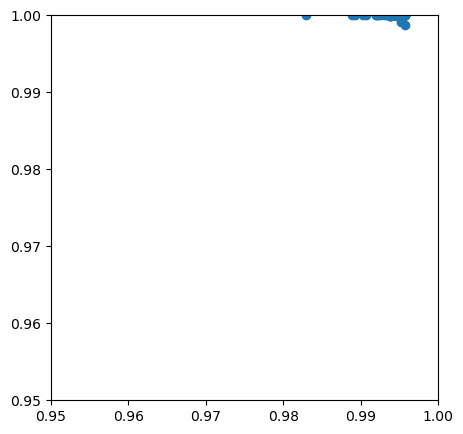

In [33]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_xlim([0.95, 1])
ax.set_ylim([0.95, 1])
ax.scatter(NN_array, bridge_array)